# Grad-CAM

Grad-CAM (Gradient-weighted Class Activation Mapping)

- https://arxiv.org/pdf/1610.02391
- https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

For the class-discriminative localization map Grad-CAM $L^c_{\text{Grad-CAM}} \in \mathbb{R}^{u \times v}$ of width $u$ and height $v$ for any class $c$, we first compute the gradient of the score for class $c$, $y^c$ (before the softmax), with respect to feature map activations $A^k$ of a convolutional layer, i.e. $\frac{\partial y^c}{\partial A^k}$. These gradients flowing back are global-average-pooled over the width and height dimensions (indexed by $i$ and $j$ respectively) to obtain the neuron importance weights $\alpha{}_{k}^c$:

$$
\alpha{}_{k}^c =
\overbrace{
    \frac{1}{Z}\sum_{i}\sum_{j}
}^{\text{global average pooling}}
\hspace{-17pt}
\underbrace{
    \vphantom{\sum_{i}\sum_{j}} \frac{\partial y^c}{\partial A_{ij}^{k}}
}_{\text{gradients via backprop}}
$$

During computation of $\alpha{}_{k}^c$ while backpropagating gradients with respect to activations, the exact computation amounts to successive matrix products of the weight matrices and the gradient with respect to activation functions till the final convolution layer that the gradients are being propagated to. Hence, this weight $\alpha{}_{k}^c$ represents a **partial linearization** of the deep network downstream from A,
and captures the **importance** of feature map $k$ for a target class $c$.

We perform a weighted combination of forward activation maps, and follow it by a ReLU to obtain,
$$
L_{\text{Grad-CAM}}^{c} = \text{ReLU} \underbrace{\left(\sum_k \alpha{}_{k}^{c} A^{k}\right)}_{\text{linear combination}}
$$

Notice that this results in a coarse heatmap of the same size as the convolutional feature
maps ($14 \times 14$) in the case of last convolutional layers of VGG and AlexNet (We find that Grad-CAM maps become progressively worse as we move to earlier convolutional layers as they have smaller receptive fields and only focus on less semantic local features.). We apply a ReLU to the linear combination of maps because we are only interested in the features that have a **positive** influence on the class of interest, i.e. pixels whose intensity should be **increased** in order to increase $y^c$. Negative pixels are likely to belong to other categories in the image. As expected, without this ReLU, localization maps sometimes highlight more than just the desired class and perform worse at localization.

The strategy is defined as follows:

- Load the VGG19 model
- Find its last convolutional layer
- Compute the most probable class
- Take the gradient of the class logit with respect to the activation maps we have just obtained
- Pool the gradients
- Weight the channels of the map by the corresponding pooled gradients
- Interpolate the heat-map

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
weights = models.VGG19_Weights.DEFAULT
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
    v2.ToPureTensor(),
])

inverse_transform = v2.Compose([
    v2.ToImage(),
    v2.Normalize(mean=[0, 0, 0], std=[1.0 / i for i in std]),
    v2.Normalize(mean=[-i for i in mean], std=[1, 1, 1]),
    v2.ToPILImage(),
])

dataset = datasets.Imagenette(
    root='./data',
    split='val',
    size='320px',
    transform=transform,
    download=True,
)

In [ ]:
len(dataset)

3925

In [ ]:
dataset.class_to_idx

{'tench': 0,
 'Tinca tinca': 0,
 'English springer': 1,
 'English springer spaniel': 1,
 'cassette player': 2,
 'chain saw': 3,
 'chainsaw': 3,
 'church': 4,
 'church building': 4,
 'French horn': 5,
 'horn': 5,
 'garbage truck': 6,
 'dustcart': 6,
 'gas pump': 7,
 'gasoline pump': 7,
 'petrol pump': 7,
 'island dispenser': 7,
 'golf ball': 8,
 'parachute': 9,
 'chute': 9}

In [ ]:
dataset.classes

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

In [ ]:
idx_to_class = {i:dataset.classes[i] for i in range(len(dataset.classes))}
idx_to_class

{0: ('tench', 'Tinca tinca'),
 1: ('English springer', 'English springer spaniel'),
 2: ('cassette player',),
 3: ('chain saw', 'chainsaw'),
 4: ('church', 'church building'),
 5: ('French horn', 'horn'),
 6: ('garbage truck', 'dustcart'),
 7: ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 8: ('golf ball',),
 9: ('parachute', 'chute')}

('church', 'church building')
(224, 224)


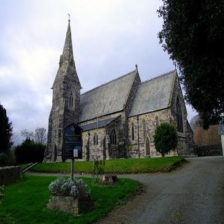

In [ ]:
idx = torch.randint(0, len(dataset), (1,)).item()
img, lbl = dataset[idx]
print(idx_to_class[lbl])
img = inverse_transform(img)
print(img.size)
img

In [ ]:
model = models.vgg19(weights=weights)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [00:51<00:00, 11.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
print(model.features[-3])  # the last convolutional layer
print(model.features[-2])  # the last activation (ReLU) layer
print(model.features[-1])  # the last pooling layer

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
idx = torch.randint(0, len(dataset), (1,)).item()
x, _ = dataset[idx]
x = x.unsqueeze(0)
print("Input                 ", x.shape)
x = model.features[:36](x)
print("ReLU(Conv(x))         ", x.shape)
x = model.features[36](x)
print("MaxPool(ReLU(Conv(x)))", x.shape)
x = torch.flatten(x, start_dim=1)
print("Flatten               ", x.shape)
x = model.classifier(x)
print("MLP(Flatten)          ", x.shape)

Input                  torch.Size([1, 3, 224, 224])
ReLU(Conv(x))          torch.Size([1, 512, 14, 14])
MaxPool(ReLU(Conv(x))) torch.Size([1, 512, 7, 7])
Flatten                torch.Size([1, 25088])
MLP(Flatten)           torch.Size([1, 1000])


The hook will be called every time a gradient with respect to the Tensor is computed. The hook should have the following signature:

```
hook(grad) -> Tensor or None
```

https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()

        # get the pretrained VGG19 model
        self.vgg = models.vgg19(weights="DEFAULT")

        # dissect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]

        # get the max pool of the features stem
        self.max_pool = self.vgg.features[36]

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation extraction
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
import requests

url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
response = requests.get(url)
response.raise_for_status()

imagenet_idx_to_class = eval(response.text)
imagenet_idx_to_class

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

torch.Size([1, 1000])
Real : ('tench', 'Tinca tinca')
Pred [0]: tench, Tinca tinca


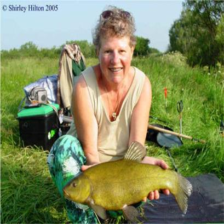

In [ ]:
# initialize the VGG model
vgg = VGG()

# set the model in evaluation mode
vgg.eval()

# get the image and true label from the dataset
idx = torch.randint(0, len(dataset), (1,)).item()
img, lbl = dataset[idx]
img = img.unsqueeze(0)

true_class = idx_to_class[lbl]

# get the logits
pred = vgg(img)
print(pred.shape)

# get the most likely prediction of the model
pred_idx = torch.argmax(pred, dim=1).item()
pred_class = imagenet_idx_to_class[pred_idx]

# print the real and predicted classes
print(f"Real : {true_class}")
print(f"Pred [{pred_idx}]: {pred_class}")
image = inverse_transform(img.squeeze())
image

Predicted Logits: tensor([33.2416], grad_fn=<SelectBackward0>)
Graidents Shape: torch.Size([1, 512, 14, 14])
Pooled Gradients Shape: torch.Size([512])
Activations Shape: torch.Size([1, 512, 14, 14])
Heatmap Shape: (14, 14)


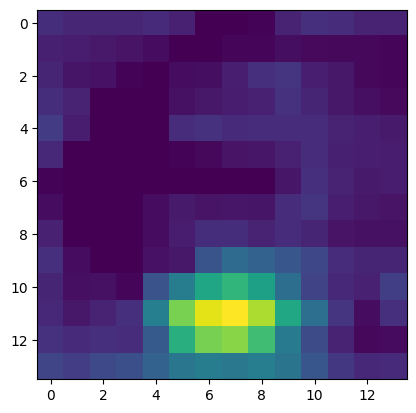

In [ ]:
print(f"Predicted Logits: {pred[:, pred_idx]}")

# get the gradient of the output w.r.t. to the parameters of the model
pred[:, pred_idx].backward()

# pull the activation gradients out of the model
gradients = vgg.get_activations_gradient()
print(f"Graidents Shape: {gradients.shape}")

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
print(f"Pooled Gradients Shape: {pooled_gradients.shape}")

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()
print(f"Activations Shape: {activations.shape}")

# weight the channels by corresponding gradients
for i in range(len(pooled_gradients)):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

heatmap = heatmap.detach().numpy()

print(f"Heatmap Shape: {heatmap.shape}")
plt.imshow(heatmap)
plt.show()

Real : ('tench', 'Tinca tinca')
Pred [0]: tench, Tinca tinca


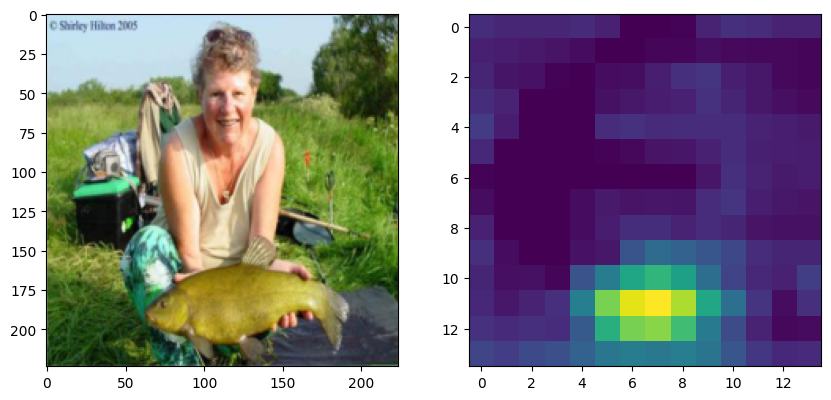

In [ ]:
print(f"Real : {true_class}")
print(f"Pred [{pred_idx}]: {pred_class}")

image = np.asarray(image)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(heatmap)
plt.show()

Real : ('tench', 'Tinca tinca')
Pred [0]: tench, Tinca tinca


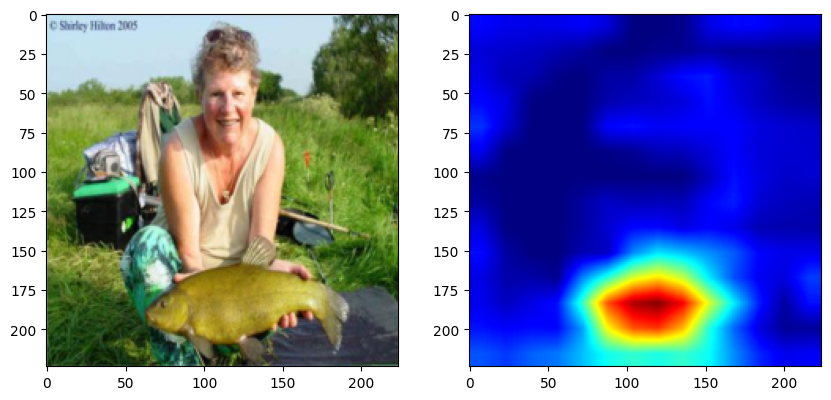

In [ ]:
print(f"Real : {true_class}")
print(f"Pred [{pred_idx}]: {pred_class}")

hmap = cv2.resize(heatmap, (image.shape[0], image.shape[1]))
hmap = np.uint8(255 * hmap)
hmap = cv2.applyColorMap(hmap, cv2.COLORMAP_JET)
hmap = cv2.cvtColor(hmap, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.asarray(image))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(hmap)
plt.show()

Real : ('tench', 'Tinca tinca')
Pred [0]: tench, Tinca tinca


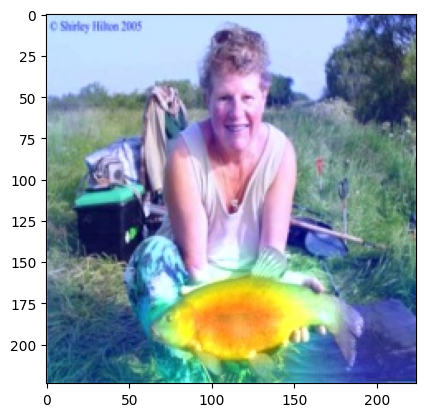

In [ ]:
print(f"Real : {true_class}")
print(f"Pred [{pred_idx}]: {pred_class}")

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
hmap = cv2.cvtColor(hmap, cv2.COLOR_RGB2BGR)
superposed_img = hmap*0.4 + image
cv2.imwrite("superimposed.jpg", superposed_img)
superimposed_img = cv2.imread("superimposed.jpg")
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
plt.imshow(superimposed_img)
plt.show()